In [29]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 414 (delta 108), reused 77 (delta 77), pack-reused 242
Receiving objects: 100% (414/414), 70.28 MiB | 24.95 MiB/s, done.
Resolving deltas: 100% (197/197), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./du

In [30]:
from dul_2021.utils.hw8_utils import *

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
from sklearn.metrics.pairwise import rbf_kernel as rbf
from torch import optim
from torch.distributions import MultivariateNormal
from torch.nn import Conv2d, ConvTranspose2d
from torch.utils import data
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:



class KernelMeanMatching(nn.Module):
    def __init__(self, dim=1, sigma=0.3, hidden=256):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
            nn.Softplus()
        )
        self.sigma = sigma

    def forward(self, input_batch):
        return self.model(input_batch)

    def get_kernel(self, x, y):
        kernel = pow(x, 2).sum(dim=1, keepdim=True) + pow(y,2).sum(dim=1) - 2 * x @ y.T
        kernel = kernel / (-2 * (pow(self.sigma, 2)))
        return kernel.exp()


class KMMTrainer:
    def __init__(self, kernel_mean_matching: KernelMeanMatching):
        self.kernel_mean_matching = kernel_mean_matching

    def fit(self, dataloader_num: DataLoader, dataloader_den: DataLoader, lr: float = 1e-3, epochs: int = 100):
        optim = torch.optim.AdamW(self.kernel_mean_matching.parameters(), lr=lr)
        self.kernel_mean_matching.train()

        epochs_iter = trange(epochs)
        postfix = {}
        for _ in epochs_iter:
            epoch_loss, iters = 0, 0
            for (batch_num, batch_den) in zip(dataloader_num, dataloader_den):
                batch_num = batch_num.to(device)
                batch_den = batch_den.to(device)

                r = self.kernel_mean_matching(batch_den)
                kernel_den_den = self.kernel_mean_matching.get_kernel(batch_den, batch_den)
                kernel_den_num = self.kernel_mean_matching.get_kernel(batch_den, batch_num)

                loss = r.T.matmul(kernel_den_den).matmul(r) - 2 * r.T.matmul(kernel_den_num).sum()
                loss /= batch_num.shape[0] * batch_num.shape[0]

                optim.zero_grad()
                loss.backward()
                optim.step()

                epoch_loss += loss.item()
                iters += 1

            postfix["loss"] = epoch_loss / iters
            epochs_iter.set_postfix(postfix)

        epochs_iter.close()


In [33]:
# distributions

In [34]:
def q1(data_nu, data_de, batch_size = 512):
  """
  data_nu - An [n_nu] dataset with samples from numerator's distribution
  data_de - An [n_de] dataset with samples from denominators's distribution
  
  Returns
    - a np.array with density ratios of np.linspace(-2., 2, num=100)
  """
  # your code goes here

  # you need to calculate density ratio on x and return it
  # x = np.linspace(-2., 2, num=100)

  data_nu = torch.tensor(data_nu.reshape(-1, 1), dtype=torch.float, device=device)
  data_de = torch.tensor(data_de.reshape(-1, 1), dtype=torch.float, device=device)
  data_nu = DataLoader(data_nu, batch_size=batch_size, shuffle=True)
  data_de = DataLoader(data_de, batch_size=batch_size, shuffle=True)
  kmm = KernelMeanMatching().to(device)
  trainer = KMMTrainer(kmm)

  trainer.fit(data_nu, data_de)

  x = np.linspace(-2., 2, num=100)
  x = torch.tensor(x.reshape(-1, 1), dtype=torch.float, device=device)

  with torch.no_grad():
      kmm.eval()
      return kmm(x).detach().cpu().numpy()

100%|██████████| 100/100 [00:11<00:00,  8.68it/s, loss=-.629]


<Figure size 432x288 with 0 Axes>

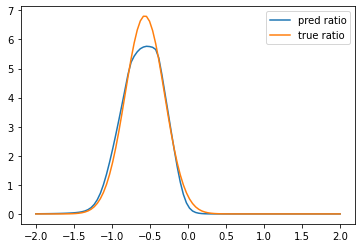

In [35]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_encoder_layers = 3
        self.out_channels = 32
        self.flatten_dim = 16
        self.latent_dim = 128
        relu = torch.nn.ReLU()
        model = [Conv2d(1, self.out_channels, 3, 1, 1)]
        in_channels = self.out_channels

        for _ in range(self.n_encoder_layers):
            if in_channels != 128:
                self.out_channels = in_channels * 2
            model.extend([relu, Conv2d(in_channels, self.out_channels, 3, 2, 1)])
            in_channels = self.out_channels

        self.model = torch.nn.Sequential(*model)
        self.linear = torch.nn.Linear(self.flatten_dim * 128 + 5, self.latent_dim)

    def forward(self, x, noise):
        output = self.model(x)
        output = torch.flatten(output, start_dim=1)
        return self.linear(torch.cat((output, noise), dim=1))


class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.n_decoder_layers = 3
        self.in_channels = 128
        self.in_img_size = 4
        self.latent_dim = 128

        self.linear = torch.nn.Linear(self.latent_dim, 128 * 4 * 4)

        relu = torch.nn.ReLU()
        out_channels = self.in_channels
        self.in_channels = self.in_channels
        model = []
        for _ in range(self.n_decoder_layers):
            if _ == 0:
                kernel_size = 3
            else:
                kernel_size = 4
            model.extend([ConvTranspose2d(self.in_channels, out_channels, kernel_size, 2, 1), relu])
            self.in_channels = out_channels
            out_channels = out_channels // 2

        self.model = torch.nn.Sequential(*model)
        self.conv_layer = Conv2d(self.in_channels, 1, 3, 1, 1)

    def forward(self, x):
        output = F.relu(self.linear(x)).reshape(x.shape[0], 128, 4, 4)
        output = self.model(output)
        output = self.conv_layer(output)
        return output


class Classifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.n_encoder_layers = 3
        self.out_channels = 32
        self.flatten_dim = 16
        self.latent_dim = 128
        relu = torch.nn.ReLU()
        model = [Conv2d(1, self.out_channels, 3, 1, 1)]
        in_channels = self.out_channels

        for _ in range(self.n_encoder_layers):
            if in_channels != 128:
                self.out_channels = in_channels * 2
            model.extend([relu, Conv2d(in_channels, self.out_channels, 3, 2, 1)])
            in_channels = self.out_channels

        self.model = torch.nn.Sequential(*model)

        self.linear_model = [torch.nn.Linear(self.flatten_dim * 128 + 128, self.latent_dim)]
        self.linear_model.extend([relu, torch.nn.Linear(self.latent_dim, self.latent_dim)])
        self.linear_model.extend([relu, torch.nn.Linear(self.latent_dim, 1)])
        self.linear_model = torch.nn.Sequential(*self.linear_model)

    def forward(self, x, z):
        output = self.model(x)
        output = torch.flatten(output, start_dim=1)
        output = self.linear_model(torch.cat((output, z), dim=1))
        return output


class AdversairalVariationalBayes:
    def __init__(self):
        super().__init__()
        self.grad_clip = 1
        self.epochs = 20
        self.lr = 1e-3
        self.verbose = 5
        self.latent_dim = 128
        self.n_samples = 100
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        self.classifier = Classifier().to(device)

        self.elbo_optimizer = torch.optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()),
                                               lr=self.lr)
        self.clas_optimizer = torch.optim.Adam(self.classifier.parameters(), lr=self.lr)
        self.noise_distribution = MultivariateNormal(torch.zeros(5, device=device), torch.eye(5, device=device))

        self.latent_distribution = MultivariateNormal(torch.zeros(self.latent_dim, device=device),
                                                      torch.eye(self.latent_dim, device=device))

    def loss(self, x):
        x = 2 * x - 1
        noise = self.noise_distribution.sample((x.shape[0],))
        z = self.encoder(x, noise)
        x_hat = self.decoder(z)
        cl = self.classifier(x, z)

        rc_loss = F.mse_loss(x, x_hat, reduction='none').view(x.shape[0], -1).sum(1)
        elbo_loss = (rc_loss + cl).mean()

        s = self.noise_distribution.sample((x.shape[0],)).detach()
        z = self.encoder(x, noise).detach()
        z_hat = self.latent_distribution.sample((x.shape[0],))

        cl_real = torch.sigmoid(self.classifier(x, z))
        cl_loss_real = F.binary_cross_entropy(cl_real, torch.ones_like(cl_real))

        cl_fake = torch.sigmoid(self.classifier(x, z_hat))
        cl_loss_fake = F.binary_cross_entropy(cl_fake, torch.zeros_like(cl_fake))

        classifier_loss = (cl_loss_real + cl_loss_fake).mean()

        return defaultdict(el_loss=elbo_loss, cl_loss=classifier_loss)

    def sample(self, n):
        with torch.no_grad():
            z = self.latent_distribution.sample((n,))
            samples = torch.clamp(self.decoder(z), -1, 1)
            samples = samples.detach().cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5
        return samples * 255.

    def validate(self, loader):
        cl_loss = []
        el_loss = []
        with torch.no_grad():
            for x in loader:
                x = x.to(device)
                losses = self.loss(x)
                el_loss.append(losses['el_loss'].item())
                cl_loss.append(losses['cl_loss'].item())
        return np.mean(el_loss), np.mean(cl_loss)

    def train_loop(self, train_loader, test_loader):
        self.encoder.train()
        self.decoder.train()
        self.classifier.train()

        train_losses = defaultdict(lambda: [])
        test_losses = defaultdict(lambda: [])

        for epoch in range(self.epochs):
            epoch_train_losses = defaultdict(lambda: [])
            for x in train_loader:
                x = x.to(device)
                torch.cuda.empty_cache()

                losses = self.loss(x)
                self.elbo_optimizer.zero_grad()
                losses['el_loss'].backward()
                self.elbo_optimizer.step()

                self.clas_optimizer.zero_grad()
                losses['cl_loss'].backward()
                self.clas_optimizer.step()

                for k in losses.keys():
                    epoch_train_losses[k].append(losses[k].item())

                if epoch % self.verbose == 0:
                    val_losses = self.validate(test_loader)
                    test_losses["el_loss"].append(val_losses[0])
                    test_losses["cl_loss"].append(val_losses[1])

            for k in epoch_train_losses.keys():
                train_losses[k].append(np.mean(epoch_train_losses[k]))

        samples = self.sample(self.n_samples)

        return train_losses, test_losses, samples


def q2(train_data, test_data):
    """
    train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
     Returns
    - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
    - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
    - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
    """
    train_data = torch.utils.data.DataLoader(torch.tensor(train_data).float().permute(0, 3, 1, 2),
                                             pin_memory=True,
                                             drop_last=False,
                                             num_workers=4,
                                             batch_size=512)

    test_data = torch.utils.data.DataLoader(torch.tensor(test_data).float().permute(0, 3, 1, 2),
                                            pin_memory=True,
                                            drop_last=False,
                                            num_workers=4,
                                            batch_size=512)

    model = AdversairalVariationalBayes()
    train_losses, test_losses, samples = model.train_loop(train_data, test_data)

    return train_losses["el_loss"], train_losses["cl_loss"], test_losses["el_loss"], test_losses["cl_loss"], samples


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


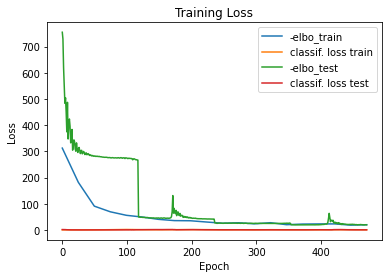

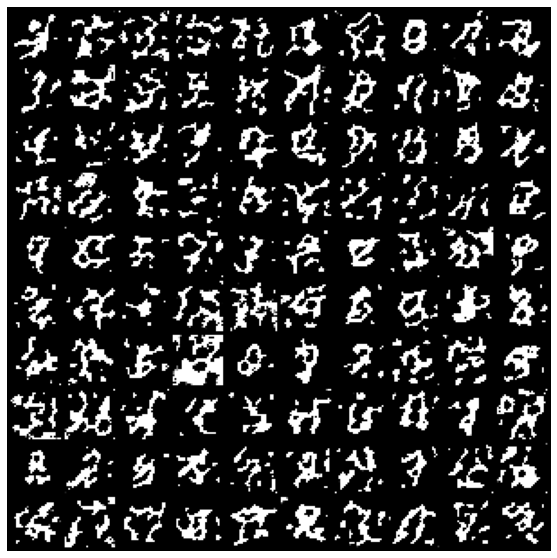

In [37]:
q2_results(q2)